# HW07: Expectation-Maximization Clustering
## Hamza Dehidi KU 0077989
### December 22, 2021

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spa
import scipy.stats as sta

## Importing Data

In [2]:
# read data into memory
X = np.genfromtxt("hw07_data_set.csv", delimiter = ",")

In [3]:
# sample size
N = X.shape[0]
# cluster count
K = 5

## Plotting the data

In [1]:
plt.figure(figsize = (8,8))
plt.plot(X[:,0], X[:,1], ".", markersize = 10, color = "black")
plt.title('five bivariate Gaussian densities',fontsize = 16)
plt.xlabel("x1",fontsize = 14)
plt.ylabel("x2",fontsize = 14);

NameError: name 'plt' is not defined

## Parameters Estimation

### Sample means

In [5]:
# loading the givin centroids(means)  
centroids = np.genfromtxt("hw07_initial_centroids.csv", delimiter = ",")

In [23]:
centroids

array([[-2.44390052, -2.5453942 ],
       [ 2.50354332,  2.51134859],
       [ 2.56726404, -2.55477253],
       [ 0.12794677,  0.15595776],
       [-2.41465305,  2.4855615 ]])

In [6]:
#Calculating the initial memberships to calculate the covariances, priors probabilities

def update_memberships(centroids, X):
    
    # calculate distances between centroids and data points
    D = spa.distance_matrix(centroids, X)
    
    # find the nearest centroid for each data point
    memberships = np.argmin(D, axis = 0)
    
    return(memberships)

In [7]:
memberships = update_memberships(centroids, X)

In [8]:
memberships;

### Calculate sample variances

$\widehat{\sigma_{c}^{2}} = \dfrac{\sum\limits_{i = 1}^{N}  \mathbb{1}(y_{i} = c)(x_{i} - \widehat{\mu_{c}})(x_{i} - \widehat{\mu_{c}})^{T}} {\sum\limits_{i = 1}^{N} \mathbb{1}(y_{i} = c)}$

In [9]:
covars = np.array([(((X[memberships == (c)]- centroids[c]).T) @ (X[memberships == (c)]- centroids[c]))/len(X[memberships == (c)]) 
                   for c in range(K)])


In [10]:
covars;

### Calculate prior probabilities

$\widehat{P}(y_{i} = c) = \dfrac{\sum\limits_{i = 1}^{N} \mathbb{1}(y_{i} = c)}{N}$

In [11]:
# calculate prior probabilities
priors = [np.mean(memberships == (c)) for c in range(K)]

In [12]:
priors;

## Algorithm Steps

$h_{c}= \dfrac{(|\Sigma_{c}|)^{-0.5}*\exp[-\dfrac{1}{2}(x - \mu_{c})^{T}\Sigma_{c}^{-1}(x - \mu_{c})] * \log P(y = c)}{\sum\limits_{c = 1}^{k}(|\Sigma_{k}|)^{-0.5}*\exp[-\dfrac{1}{2}(x - \mu_{k})^{T}\Sigma_{c}^{-1}(x - \mu_{k})] * \log P(y = k)}$




In [13]:
def e_step(X,centroids,covars,priors):
    all_posterior_prob = np.zeros((X.shape[0], 0))
    for c in range(K):
        posteriors = np.vstack([(np.linalg.det(covars[c])**-0.5)*
                            np.exp(- 0.5 * (X[j] - centroids[c]).T @ np.linalg.inv(covars[c]) @ (X[j] - centroids[c]))
                                   *(priors[c]) for j in range(X.shape[0])])
       
        all_posterior_prob = np.hstack((all_posterior_prob,posteriors))
    
    h = all_posterior_prob/np.sum(all_posterior_prob,axis =1)[:,None]
    
    return h

In [14]:
def m_step(h):
    
    h =  e_step(X,centroids,covars,priors)
    for c in range(K):
        centroids[c] = np.sum(np.multiply(X,h[:,c][:,None]),axis = 0)/np.sum(h[:,c])
          
        covars[c] = (((X- centroids[c]).T) @ np.multiply((X- centroids[c]),h[:,c][:,None]))/np.sum(h[:,c])
    
        priors[c] = np.sum(h[:,c])/N
        
    return centroids,covars,priors

## Visualization

In [15]:
def plot_current_state(centroids, memberships, X):
    cluster_colors = np.array(["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#b15928",
                               "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6", "#ffff99"])
    
    # evaluate the function on a grid
    x1_interval = np.linspace(-5, +5, 81)
    x2_interval = np.linspace(-5, +5, 81)
    x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)
    X_draw = np.transpose(np.vstack((x1_grid.flatten(), x2_grid.flatten())))
    z_values = e_step(X_draw,centroids,covars,priors)
    
    if memberships is None:
        plt.plot(X[:,0], X[:,1], ".", markersize = 10, color = "black")
    else:
        for c in range(K):
            plt.plot(X[memberships == c, 0], X[memberships == c, 1], ".", markersize = 10,
                     color = cluster_colors[c])
    for c in range(K):
        z= sta.multivariate_normal.pdf(X_draw,centroids[c],covars[c])
        plt.contour(x1_grid, x2_grid,np.reshape(z,x1_grid.shape),linestyles = ["solid"],colors =cluster_colors[c],levels = [0.05])
        
        z_original = sta.multivariate_normal.pdf(X_draw,original_centroids[c],original_covars[c])
        plt.contour(x1_grid, x2_grid,np.reshape(z_original,x1_grid.shape),linestyles = ["dashed"],colors ="k",levels = [0.05])
        
    plt.title('five bivariate Gaussian densities, densities drawn at 0.05',fontsize = 16)
    plt.xlabel("x1",fontsize = 14)
    plt.ylabel("x2",fontsize = 14)

In [16]:
# Original parameters
original_centroids = np.array([[+2.5, +2.5],
                        [-2.5, +2.5],
                        [-2.5, -2.5],
                        [+2.5, -2.5],
                        [+0.0, +0.0]])
# covariance parameters
original_covars = np.array([[[+0.8, -0.6],
                               [-0.6, +0.8]],
                              [[+0.8, +0.6],
                               [+0.6, +0.8]],
                              [[+0.8, -0.6], 
                               [-0.6, +0.8]],
                              [[+0.8, +0.6], 
                               [+0.6, +0.8]],                              
                              [[+1.6, +0.0],
                               [+0.0, +1.6]]])

## Iterations

In [17]:
iteration = 1

while iteration < 101:
    h = e_step(X,centroids,covars,priors)
    centroids,covars,priors = m_step(h)
    
    if iteration == 100:
        print("Iteration#{}:".format(iteration))
        print('centroids =\n',centroids)
        print('covars =\n',covars)
        print('priors =\n',priors)
        
    iteration = iteration + 1

Iteration#100:
centroids =
 [[-2.44390052 -2.5453942 ]
 [ 2.50354332  2.51134859]
 [ 2.56726404 -2.55477253]
 [ 0.12794677  0.15595776]
 [-2.41465305  2.4855615 ]]
covars =
 [[[ 0.62058759 -0.46763353]
  [-0.46763353  0.84642585]]

 [[ 0.8179419  -0.76341516]
  [-0.76341516  0.94491495]]

 [[ 0.8163404   0.59355262]
  [ 0.59355262  0.73890342]]

 [[ 1.6403045   0.17900485]
  [ 0.17900485  1.76477494]]

 [[ 0.85137993  0.60105415]
  [ 0.60105415  0.70199587]]]
priors =
 [0.16416956996388804, 0.14616745105725404, 0.16612981810698918, 0.3451050593864021, 0.17842810148546662]


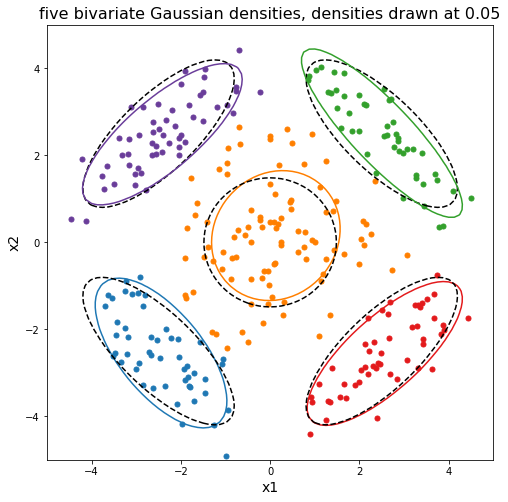

In [18]:
plt.figure(figsize = (8, 8)) 
plot_current_state(centroids, np.argmax(h,axis=1), X);

In [19]:
cluster_colors = np.array(["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#b15928",
                           "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6", "#ffff99"])

# evaluate the function on a grid
x1_interval = np.linspace(-5, +5, 81)
x2_interval = np.linspace(-5, +5, 81)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)
X_draw = np.transpose(np.vstack((x1_grid.flatten(), x2_grid.flatten())))
z_values = e_step(X_draw,centroids,covars,priors)

In [20]:
%matplotlib notebook

<IPython.core.display.Javascript object>


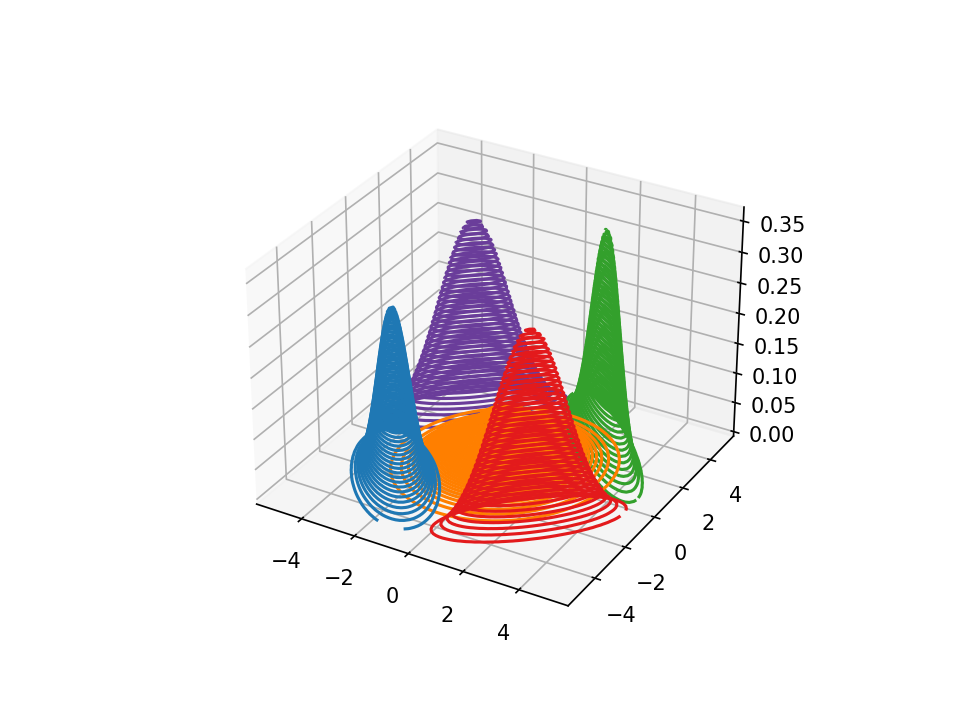

In [21]:
fig = plt.figure()
ax = plt.axes(projection='3d')
for c in range(K):
        z= sta.multivariate_normal.pdf(X_draw,centroids[c],covars[c])
        ax.contour3D(x1_grid, x2_grid,np.reshape(z,x1_grid.shape),50,linestyles = ["solid"],colors =cluster_colors[c])

In [22]:
np.argmax(h,axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3], d